In [94]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 27 18:55:35 2019

@author: JM
"""

import os
import re
import nltk
import numpy as np
from tqdm import tqdm
from collections import Counter
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize
from tkinter.filedialog import askopenfilename 
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter,resolve1
from pdfminer.pdfdevice import PDFDevice, TagExtractor
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import XMLConverter, HTMLConverter, TextConverter
from pdfminer.cmapdb import CMapDB
from pdfminer.layout import LAParams
from pdfminer.image import ImageWriter


class preprocessing:
    def __init__(self, input_path, output_path=None):
        self.input_path = input_path
        self.output_path = output_path

    def isExistFile(self):
        file_name = self.output_path.split('/')[-1]

        for i in os.listdir("."):
            if file_name == i:
                return True

        return False

    def pdf2txt(self):
        '''
        =============================

        return : str, text File path
        '''

        # input
        password=''
        pagenos=set()
        maxpages=0

        # output
        imagewriter = None
        rotation = 0
        codec = 'UTF-8'
        pageno = 1
        scale = 1
        caching = True
        showpageno = True
        laparams = LAParams()

        infp = open(self.input_path,"rb")
        
        if self.output_path == None:
            self.output_path = self.input_path[:-4]+'_trans.txt'
            outfp = open(self.output_path,"w",encoding='UTF8')
        else:
            outfp = open(self.output_path,"w",encoding='UTF8')
            
            
        #page total num
        parser = PDFParser(infp)
        document = PDFDocument(parser)
        page_total_num = resolve1(document.catalog['Pages'])['Count']

        #
        rsrcmgr = PDFResourceManager(caching=caching)

        # pdf -> text converter
        device = TextConverter(rsrcmgr,
                               outfp,
                               codec=codec,
                               laparams=laparams, 
                               imagewriter=imagewriter)

        # pdf -> text interpreter
        interpreter = PDFPageInterpreter(rsrcmgr,device)

        # pdf -> text start
        with tqdm(total=page_total_num) as pbar:
            for page in PDFPage.get_pages(infp,
                                          pagenos,
                                          maxpages,
                                          password=password,
                                          caching=caching,
                                          check_extractable=True):

                page.rotate = (page.rotate+rotation) % 360     
                interpreter.process_page(page)

                pbar.update(1)

        print('[INFO] pdf -> text')

        outfp.close()
        infp.close()
        
        return self.output_path
    
    def clean_text(self):
        '''
        ==========================
        '''

        f = open(self.output_path,"rb")
        line_list = []

        while True:
            line = f.readline()
            line_list.append(line)
            if not line: break

        f.close()

        # remove nextline
        word = b" ".join(line_list).split()
        sentences = b" ".join(word)


        # remove ASCII
        # define pattern 
        pattern = re.compile(b"[\x80-\xff]")
        sentences = re.sub(pattern,b"",sentences)

        sentences = sentences.split(b". ")

        f = open(self.output_path,"wb")

        for sentence in sentences:
            sentence = sentence.replace(b"- ",b'')
            sentence = sentence.replace(b"-",b'')
            #cleaned_txt.append(sentence)
            f.write(sentence + b'. ')

        f.close()
        
        print('[INFO] clean text file')

    def word_Frequency(self):
        f = open(self.output_path,"r")

        text = f.readline()

        # 단어의 빈도수
        shortword = re.compile(r'\W*\b\w{1,2}\b')
        text = shortword.sub('', text)

        stop_words = set(stopwords.words('english')) 
        word_tokens = word_tokenize(text)

        result = [] 

        # 불용어 제거
        for w in word_tokens: 
            if w not in stop_words: 
                parsing = ''.join([i for i in w if not i.isdigit()]) 
                parsing = re.sub('[-=+,#/\?:^$.@*\"※~&%}{ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', parsing)


                if parsing and parsing.isdigit() == False and len(parsing) > 2:
                    result.append(w)  

        cnt = Counter(result)
        
        print('[INFO] generation word frequency')
        
        return cnt
    
def gen_example(text_path, word_list):
    '''
    text_path : list, text file paths
    word : str, generate example
    
    ==================================
    
    return : str
    '''
    
    example = {}
    
    max_len = len(word_list)
    
    for path in text_path:
        f = open(path,"r")

        text = f.readline()
        
        sent_tokenize_list = sent_tokenize(text)
        
        for sentence in sent_tokenize_list:
            for word in word_list:
                if word in sentence:
                    example[word] = sentence
                    word_list.remove(word)
                    break
                
        if len(example) == max_len:
            break
                
    return example


input_path = ['C:/Users/JM/Desktop/MCNN.pdf','C:/Users/JM/Desktop/YOLO.pdf']

result = Counter('')
text_path = []


for path in input_path:
    pdf = preprocessing(path)
    output_path = pdf.pdf2txt()
    text_path.append(output_path)
    
    pdf.clean_text()
    cnt = pdf.word_Frequency()
    
    result += cnt


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  2.04it/s]


[INFO] pdf -> text
[INFO] clean text file
[INFO] generation word frequency


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:08<00:00,  5.48it/s]


[INFO] pdf -> text
[INFO] clean text file
[INFO] generation word frequency


In [95]:
sorted_cnt = sorted(result.items(), key=lambda t : t[1],reverse=True)
sorted_values = sorted(result.values(), reverse=True)
sorted_keys = sorted(result, key=result.get, reverse=True)

sorted_keys[:30]

['image',
 'crowd',
 'box',
 'object',
 'density',
 'dataset',
 'cell',
 'YOLO',
 'detection',
 'layer',
 'images',
 'grid',
 'MCNN',
 'bounding',
 'network',
 'map',
 'model',
 'The',
 'different',
 'Part',
 'training',
 'counting',
 'confidence',
 'class',
 'number',
 'error',
 'data',
 'methods',
 'method',
 'score']

In [99]:
def gen_example(text_path, word_list):
    '''
    text_path : list, text file paths
    word : str, generate example
    
    ==================================
    
    return : dic {'word' : 'sentence'}
    '''
    
    example = {}
    
    max_len = len(word_list)
    
    for path in text_path:
        f = open(path,"r")

        text = f.readline()
        
        sent_tokenize_list = sent_tokenize(text)
        
        for sentence in sent_tokenize_list:
            for word in word_list:
                if word in sentence:
                    example[word] = sentence
                    word_list.remove(word)
                    break
                
        if len(example) == max_len:
            break
                
    return example

In [100]:
gen_example(text_path,sorted_keys[:30])

{'MCNN': 'The proposed MCNN allows the input image to be of arbitrary size or resolution.',
 'Part': 'Since we do not have tracked features and it is difcult to handcraft features for all different scales, we have to resort (a) (b) Figure 1: (a) Representative images of Part A in our new crowd dataset.',
 'The': 'The limitation of such detectionbased methods is that occlusion among people in a clustered environment or in a very dense crowd signicantly affects the performance of the detector hence the nal estimation accuracy.',
 'YOLO': 'YOLO  YOLO  Written by  (e2g1234@naver.com) Written by  (e2g1234@naver.com) YOLO(You Only Look Once) YOLO(You Only Look Once)   object detection    YOLO .',
 'bounding': '(1) input image 448 x 448  resize (1) input image 448 x 448  resize (2) image  single convolution network  (2) image  single convolution network  (3)       threshold    (3)       threshold    Detection   Detection    RCNN  RCNN p   detection  p   detection  p region proposal   p region

In [34]:
sorted_cnt = sorted(result.items(), key=lambda t : t[1],reverse=True)
sorted_values = sorted(result.values(), reverse=True)
sorted_keys = sorted(result, key=cnt.get, reverse=True)

print(sorted_cnt[:30])

[('image', 93), ('crowd', 92), ('box', 86), ('object', 80), ('density', 71), ('dataset', 64), ('cell', 58), ('YOLO', 54), ('detection', 53), ('layer', 50), ('images', 49), ('grid', 49), ('MCNN', 48), ('bounding', 48), ('network', 46), ('map', 42), ('model', 37), ('The', 36), ('different', 35), ('Part', 34), ('training', 34), ('counting', 33), ('confidence', 31), ('class', 31), ('number', 29), ('error', 29), ('data', 28), ('methods', 25), ('method', 25), ('score', 23)]


In [35]:
import pytagcloud
import pandas as pd
import webbrowser

def generate_cloud(dic, top, save_path):
    taglist = pytagcloud.make_tags(dict(dic[:top]).items())
    pytagcloud.create_tag_image(taglist, save_path, size=(360, 280), rectangular=False)

In [36]:
generate_cloud(sorted_cnt, 50, './cloud.jpg')

In [37]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print("Matplotlib version", matplotlib.__version__)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Matplotlib version 3.0.2


In [38]:
import plotnine
from plotnine import *
print("plontnine version :",plotnine.__version__)

plontnine version : 0.5.1


C:\Users\JM\AppData\Local\conda\conda\envs\py35\lib\site-packages\plotnine\guides\guides.py:198: UserWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
  "variable to it".format(output))


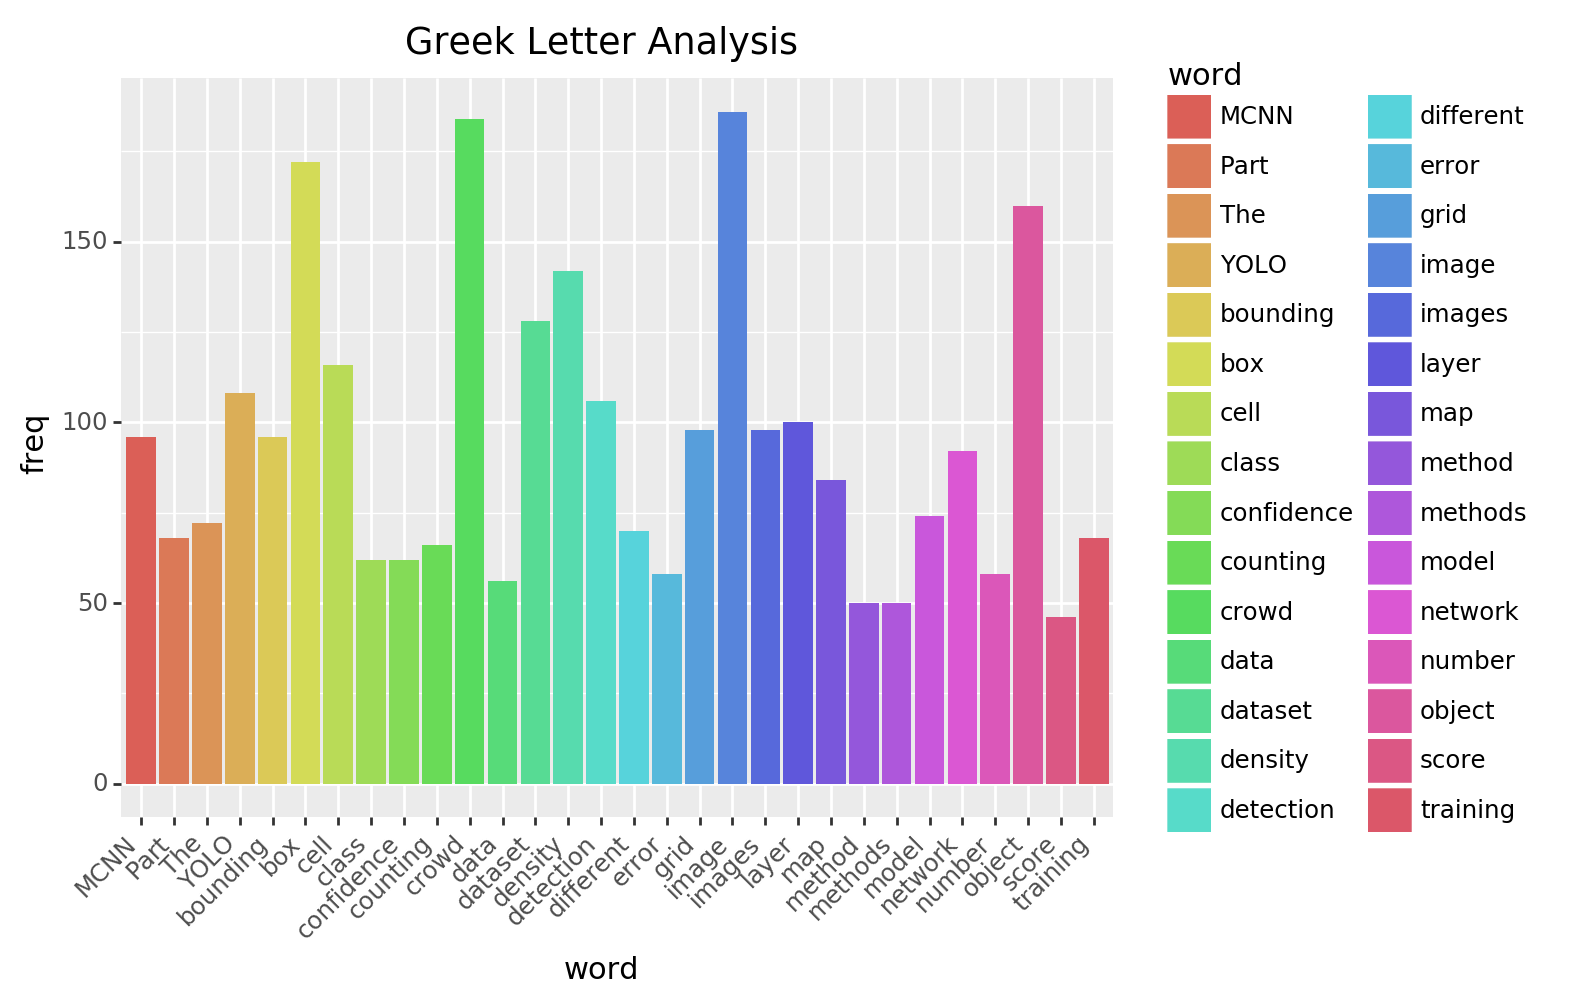

<ggplot: (-9223371908140871406)>

In [40]:
df = pd.DataFrame(sorted_cnt[:30],columns=['word','freq'])

df = pd.DataFrame({
    'word' : sorted_keys[:30] * 2,
    'freq' : sorted_values[:30] * 2
})


(ggplot(df)
 + geom_col(aes(x='word',y='freq',fill='word'))
 + scale_color_hue(l=0.45)                                  # some contrast to make the lines stick out
 + ggtitle('Greek Letter Analysis')
 + theme(axis_text_x=element_text(angle=45, hjust=1))
)